<a href="https://colab.research.google.com/github/askuts/boots/blob/main/boost_tinkoff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
# задача с конкурса Tinkoff: https://boosters.pro/championship/tinkoff1/overview
#Датасет содержит данные о кредитах на покупку электроники, которые были одобрены Tinkoff.ru.
# Необходимо предсказать, выберет ли покупатель кредит от Tinkoff.ru
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
# записываем CSV-файл в объект DataFrame
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/credit_tinkoff.csv', encoding='cp1251', sep=';')

In [107]:
# смотрим на первые пять строк
data.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,NaN,NaN,UMN,"59998,00",10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,NaN,MAR,UMN,"10889,00",6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,3,M,32.0,MAR,SPC,"10728,00",12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,4,F,27.0,NaN,SPC,"12009,09",12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,5,M,45.0,NaN,SPC,NaN,10,1.1,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0


In [108]:
#проверяем типы данных и заполненность столбцов
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133200 entries, 0 to 133199
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             133200 non-null  int64  
 1   gender                133200 non-null  object 
 2   age                   133197 non-null  float64
 3   marital_status        133197 non-null  object 
 4   job_position          133200 non-null  object 
 5   credit_sum            133198 non-null  object 
 6   credit_month          133200 non-null  int64  
 7   tariff_id             133200 non-null  float64
 8   score_shk             133193 non-null  object 
 9   education             133195 non-null  object 
 10  living_region         133047 non-null  object 
 11  monthly_income        133195 non-null  float64
 12  credit_count          126018 non-null  float64
 13  overdue_credit_count  126018 non-null  float64
 14  open_account_flg      133200 non-null  int64  
dtype

**1. Обработка числовых признаков**

- Преобразование credit_sum и score_shk:

  Эти колонки хранятся в строковом формате (object) и содержат числа с запятыми. Для корректной обработки их нужно преобразовать в числовые значения.
- Заполнение пропусков медианными значениями для `age`, `credit_sum`, `monthly_income`, `score_shk`.
- Заполнение пропусков -1 для `credit_count` и `overdue_credit_count`, так как пропущенные значения сигнализируют об отсутствии данных о кредитах соответствующих клиентов.

In [109]:
# преобразуем credit_sum и score_shk
data[['credit_sum', 'score_shk']] = data[['credit_sum', 'score_shk']].replace(',', '.', regex=True).apply(pd.to_numeric)

# заполним пропуски в соответствии с определенными выше шагами
data[['age', 'credit_sum']] = data[['age', 'credit_sum']].fillna(data[['age', 'credit_sum']].median())
data[['score_shk', 'monthly_income']] = data[['score_shk', 'monthly_income']].fillna(data[['score_shk', 'monthly_income']].median())
data[['credit_count', 'overdue_credit_count']] = data[['credit_count', 'overdue_credit_count']].fillna(-1)

2. Обработка категориальных признаков
  
  2.1. Обработка пропусков:

  - Заполнение категориальными значениями, такими как Unknown, колонок `marital_status` и `education`.

  2.2. Преобразование категориальных признаков:

  - Применение методов факторизации и дамми-кодирования к категориям (`gender`, `marital_status`, `job_position`, `education`).

In [110]:
# заполняем пропуски значением 'Unknown' в столбцах 'marital_status' и 'education'
data[['marital_status', 'education']] = data[['marital_status', 'education']].fillna('Unknown')

In [111]:
# кодируем пол методом факторизации
data['gender'] = pd.factorize(data['gender'])[0]

In [112]:
# создание словаря с порядковыми значениями для каждого уровня образования
education_order = {
    'SCH': 0,     # Школьное образование
    'UGR': 1,     # Степень бакалавра
    'GRD': 2,     # Диплом о высшем образовании
    'ACD': 3,     # Академическое образование
    'PGR': 4,     # Постдипломное образование
    'Unknown': -1 # Неизвестное образование (можно выделить в отдельную категорию)
}

# Применение кодирования к столбцу образование
data['education_encoded'] = data['education'].map(education_order)

In [113]:
data.drop(['education'], axis=1, inplace=True)

In [114]:
# удаляем столбец с номером клиента (так как он незначимый)
data.drop(['client_id'], axis=1, inplace=True)

In [115]:
# посмотрим, какие результаты у нас получились
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133200 entries, 0 to 133199
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                133200 non-null  int64  
 1   age                   133200 non-null  float64
 2   marital_status        133200 non-null  object 
 3   job_position          133200 non-null  object 
 4   credit_sum            133200 non-null  float64
 5   credit_month          133200 non-null  int64  
 6   tariff_id             133200 non-null  float64
 7   score_shk             133200 non-null  float64
 8   living_region         133047 non-null  object 
 9   monthly_income        133200 non-null  float64
 10  credit_count          133200 non-null  float64
 11  overdue_credit_count  133200 non-null  float64
 12  open_account_flg      133200 non-null  int64  
 13  education_encoded     133200 non-null  int64  
dtypes: float64(7), int64(4), object(3)
memory usage: 14.

In [116]:
# проверим количество категорий для переменной living_region
category_counts = data['living_region'].value_counts()
print(category_counts)

living_region
ОБЛ МОСКОВСКАЯ                   9571
КРАСНОДАРСКИЙ КРАЙ               5854
САНКТ-ПЕТЕРБУРГ                  4376
МОСКВА                           4292
ТАТАРСТАН РЕСП                   4043
                                 ... 
ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ       1
РЕСПУБЛИКАТАТАРСТАН                 1
МЫТИЩИНСКИЙ Р-Н                     1
ГУСЬ-ХРУСТАЛЬНЫЙ Р-Н                1
ОБЛ. БЕЛГОРОДСКАЯ                   1
Name: count, Length: 287, dtype: int64


In [117]:
# видим, что переменная нуждается в серьезной предобработке,
# так как в РФ всего 89 субъектов, а категорий у нас 287))

In [118]:
# для этого подгрузим файл с корректным названием регионов
reg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/region.csv')
reg.head()

,"NAME,C,40","SOCR,C,10","CODE,C,13","INDEX,C,6","GNINMB,C,4","OCATD,C,11","ISO,C,6"
0,Адыгея,Респ,100000000000,385000.0,100,79000000000,RU-AD
1,Башкортостан,Респ,200000000000,452000.0,200,80000000000,RU-BA
2,Бурятия,Респ,300000000000,671000.0,300,81000000000,RU-BU
3,Алтай,Респ,400000000000,649000.0,400,84000000000,RU-AL
4,Дагестан,Респ,500000000000,368000.0,500,82000000000,RU-DA


In [119]:
!pip install rapidfuzz

In [120]:
data[['living_region']] = data[['living_region']].fillna('Unknown')

reg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/region.csv')
reg.head()

,"NAME,C,40","SOCR,C,10","CODE,C,13","INDEX,C,6","GNINMB,C,4","OCATD,C,11","ISO,C,6"
0,Адыгея,Респ,100000000000,385000.0,100,79000000000,RU-AD
1,Башкортостан,Респ,200000000000,452000.0,200,80000000000,RU-BA
2,Бурятия,Респ,300000000000,671000.0,300,81000000000,RU-BU
3,Алтай,Респ,400000000000,649000.0,400,84000000000,RU-AL
4,Дагестан,Респ,500000000000,368000.0,500,82000000000,RU-DA


In [121]:
from rapidfuzz import process

# приведем названия регионов к единому регистру
valid_regions = reg['NAME,C,40'].str.lower()
data['living_region'] = data['living_region'].str.lower().str.strip()

# проверим living_region на схожесть с корректными названиями регионов
data['living_region'] = data['living_region'].apply(
    lambda x: process.extractOne(x, valid_regions, score_cutoff=70)[0] if process.extractOne(x, valid_regions, score_cutoff=70) else x
)

# Проверка результата
print(data['living_region'].value_counts())

living_region
московская              10045
москва                   7224
краснодарский            6548
санкт-петербург          6462
татарстан                5987
                        ...  
эвенкийский ао              1
гусь-хрустальный р-н        1
алтайский                   1
дальний восток              1
74                          1
Name: count, Length: 94, dtype: int64


In [122]:
# видим, что названия регионов приведены к единому виду
# записи с неопределенными названиями регионов запишем как Unknown
region_count = data['living_region'].value_counts()
data['living_region'] = data['living_region'].apply(lambda x: 'Unknown' if region_count[x] < 15 else x)

# Проверка результата
print(data['living_region'].value_counts())

living_region
московская         10045
москва              7224
краснодарский       6548
санкт-петербург     6462
татарстан           5987
                   ...  
дагестан              51
чеченская             24
Unknown               24
чукотский             22
ингушетия             15
Name: count, Length: 84, dtype: int64


In [123]:
# Стандартизация числовых признаков
scaler = StandardScaler()
num_cols = ['age', 'credit_sum', 'monthly_income', 'credit_count', 'overdue_credit_count', 'tariff_id', 'score_shk']
data[num_cols] = scaler.fit_transform(data[num_cols])

In [124]:
data.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg,education_encoded
0,0,-0.237089,Unknown,UMN,2.087196,10,1.172310,-0.063092,краснодарский,-0.402476,-0.503645,3.211052,0,2
1,1,-0.237089,MAR,UMN,-0.935192,6,-0.948484,-0.063092,москва,-0.203960,0.032443,0.030871,0,-1
2,0,-0.426789,MAR,SPC,-0.945101,12,-0.948484,-0.063092,саратовская,-0.203960,1.640707,0.030871,0,-1
3,1,-0.901039,Unknown,SPC,-0.866257,12,-0.948484,-0.063092,волгоградская,-0.203960,0.032443,0.030871,0,-1
4,0,0.806261,Unknown,SPC,-0.299899,10,-0.948484,-0.385613,челябинская,-0.203960,-0.503645,0.030871,0,0


In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133200 entries, 0 to 133199
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                133200 non-null  int64  
 1   age                   133200 non-null  float64
 2   marital_status        133200 non-null  object 
 3   job_position          133200 non-null  object 
 4   credit_sum            133200 non-null  float64
 5   credit_month          133200 non-null  int64  
 6   tariff_id             133200 non-null  float64
 7   score_shk             133200 non-null  float64
 8   living_region         133200 non-null  object 
 9   monthly_income        133200 non-null  float64
 10  credit_count          133200 non-null  float64
 11  overdue_credit_count  133200 non-null  float64
 12  open_account_flg      133200 non-null  int64  
 13  education_encoded     133200 non-null  int64  
dtypes: float64(7), int64(4), object(3)
memory usage: 14.

In [126]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns

In [127]:
# Проверка баланса целевой переменной
print(f"Распределение целевой переменной (open_account_flg):\n{data['open_account_flg'].value_counts(normalize=True)}")

Распределение целевой переменной (open_account_flg):
open_account_flg
0    0.823986
1    0.176014
Name: proportion, dtype: float64


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint, uniform

In [ ]:
# Преобразуем категориальные переменные в тип category
categorical_columns = ['marital_status', 'job_position', 'living_region']
for col in categorical_columns:
    data[col] = data[col].astype('category')

In [ ]:
# Выбираем целевую переменную и признаки
X = data.drop('open_account_flg', axis=1)
y = data['open_account_flg']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Рассчитываем вес положительного класса
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

In [ ]:
# Инициализация модели XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                      enable_categorical=True, scale_pos_weight=scale_pos_weight,
                      random_state=42)

In [ ]:
# Определяем параметры для случайного поиска
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.5, 0.5),  # from 0.5 to 1.0
    'colsample_bytree': uniform(0.5, 0.5)  # from 0.5 to 1.0
}

# Настройка RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   n_iter=50, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1, random_state=42)

In [ ]:
# Обучение с использованием RandomizedSearchCV
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.5079831261101071, 'learning_rate': 0.056178765124429805, 'max_depth': 6, 'n_estimators': 160, 'subsample': 0.8416317594127292}
ROC-AUC: 0.7694


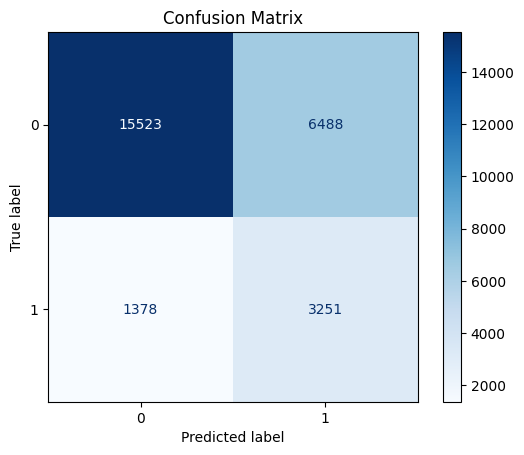

In [129]:
# Обучение с использованием RandomizedSearchCV
random_search.fit(X_train, y_train)

# Получаем лучшие параметры и модель
best_model = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

# Прогнозирование классов
y_pred = best_model.predict(X_test)

# Прогнозирование вероятностей и оценка ROC-AUC
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC-AUC: {roc_auc:.4f}")

# Вычисление матрицы ошибок
cm = confusion_matrix(y_test, y_pred)

# Отображение матрицы ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

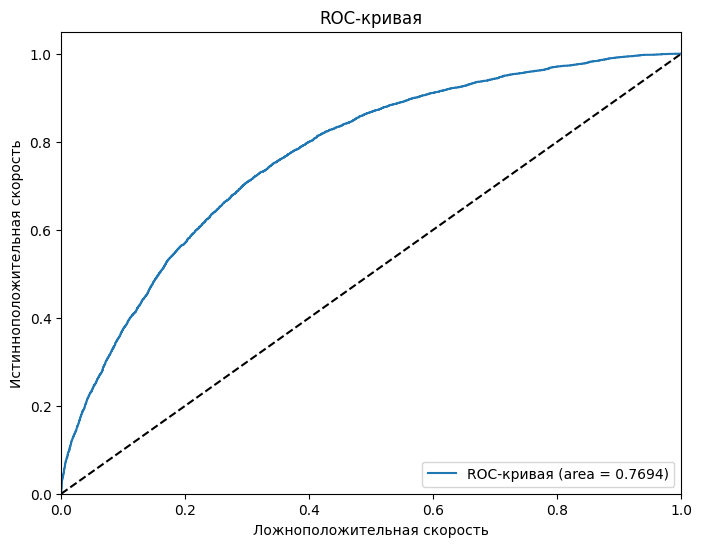

In [131]:
from sklearn.metrics import roc_curve

# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-кривая (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Линия случайного классификатора
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложноположительная скорость')
plt.ylabel('Истинноположительная скорость')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()

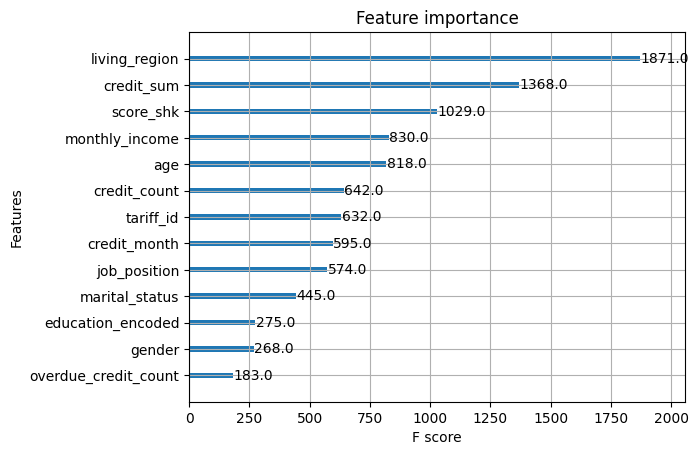

In [133]:
from xgboost import plot_importance

# Визуализация важности признаков
plot_importance(best_model)
plt.show()

In [ ]:
# Регион проживания, сумма кредита, внутренняя скоринговая оценка, месячный доход и возраст
# имеют наибольшее влияние на вероятность выбора кредита в Тинькоффе.